In [1]:
import pandas as pd
import numpy as np
import torch 
import matplotlib.pyplott as plt
import os

In [2]:
'''ctr=0
Alldata=pd.DataFrame()
for maxenergy in os.listdir('Allspecs/')[-6:]:
    path='Allspecs/'+maxenergy +'/'
    for filename in os.listdir(path):
        _,el1,size,el2=filename.split('_')
        el2=el2[:-4]
        size=float(size[:-2])
        name=str((el1,el2,size,maxenergy))
        singledata=pd.read_csv(path+ filename,sep=' ',names=['E',name])
        Alldata=pd.concat([Alldata,singledata[name]],axis=1)
        #Alldata[str((maxenergy,el1,el2,size))]=singledata['I']
        #ctr=ctr+1
    print (maxenergy)'''

"ctr=0\nAlldata=pd.DataFrame()\nfor maxenergy in os.listdir('Allspecs/')[-6:]:\n    path='Allspecs/'+maxenergy +'/'\n    for filename in os.listdir(path):\n        _,el1,size,el2=filename.split('_')\n        el2=el2[:-4]\n        size=float(size[:-2])\n        name=str((el1,el2,size,maxenergy))\n        singledata=pd.read_csv(path+ filename,sep=' ',names=['E',name])\n        Alldata=pd.concat([Alldata,singledata[name]],axis=1)\n        #Alldata[str((maxenergy,el1,el2,size))]=singledata['I']\n        #ctr=ctr+1\n    print (maxenergy)"

In [3]:
Alldata=pd.read_pickle('allspecs.pkl')
Alldata=Alldata[9:]
Alldata=Alldata/Alldata.sum(0)
Alldata['E']=Alldata.index+1
Alldata=Alldata.copy()

/tmp/ipykernel_5845/3221147074.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Alldata['E']=Alldata.index+1


In [4]:
!pip install openpyxl

In [5]:
monochromatic=pd.read_excel('Глубинные распределения.Вода.xlsx',header=1,skiprows=[0,1,1004,1005,1006],names=['N']+[str((a+10)) for a in range(241)])
monochromaticnorm=monochromatic/monochromatic.sum(0)
monochromaticnorm['N']=monochromatic['N']

In [6]:
distributions=(np.array(monochromaticnorm[monochromaticnorm.columns[1:]])@np.array(Alldata.fillna(0))[:,:-1]).T
specs=np.array(Alldata[Alldata.columns[:-1]].fillna(0.0)).T
basis=np.array(monochromaticnorm[monochromaticnorm.columns[1:]])
basis=torch.tensor(basis).cuda()

In [7]:
class Dosedistr(torch.nn.Module):
    def __init__(self, N_inputs=51561):
        super().__init__()
        self.specs=torch.nn.parameter.Parameter(data=torch.rand(241,N_inputs)/100, requires_grad=True)
    def forward(self, basis):
        outs=basis@self.specs
        return outs.T

In [8]:
def trainstep(model,basis,target, optimizer,lossfn=torch.nn.MSELoss()):
    optimizer.zero_grad()
    out=model(basis)
    l2_reg=0
    #model.spectrum.weight.data[:,:,:]=model.spectrum.weight.data[:,:,:]/model.spectrum.weight.data[:,:,:].sum(1,keepdim=True)
    #for param in model.parameters():
    gradx=(model.specs[1:-1,:]-model.specs.roll(1,-2)[1:-1,:])*1
    l2_smooth = gradx.square().mean()
    loss=(lossfn(out, target)*10000+l2_smooth*1000)*target.shape[0]
    #lossfn(out, target)*10000+l2_smooth
    loss.backward()
    optimizer.step()
    for p in model.parameters():
        p.data.clamp_(0)
    return loss

In [9]:
distributions.shape

(51561, 1000)

In [10]:
device='cuda'
dose=Dosedistr(51561).to(float).to(device)
dose.train()

Dosedistr()

In [11]:
lossesADAM=[]
optimizerADAM=torch.optim.Adam(dose.parameters(), lr=0.0001)
for i in range(30900):
    #print(i)
    if i%100==51:
        continue
        lossesADAM.append(loss.detach().cpu().numpy())
    loss=trainstep(dose, basis.to(device),torch.tensor(distributions).to(device),optimizerADAM,lossfn=torch.nn.L1Loss())
    if i%100==0:
        print(i,loss,dose.specs[0][0])
    if i<-2000 and i%200==1:
        dose.specs.data=dose.specs.data+torch.rand(dose.specs.data.shape).to(device)*0.01
outs[number]=dose.specs.data.cpu().detach().numpy()

0 tensor(184661.6774, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>) tensor(0.0014, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
100 tensor(66015.7000, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>) tensor(0.0113, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
200 tensor(35056.9329, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>) tensor(0.0187, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
300 tensor(22703.6686, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>) tensor(0.0132, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
400 tensor(16132.8356, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>) tensor(0.0042, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
500 tensor(12140.7997, device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>) tensor(0., device='cuda:0', dtype=torch.float64, 

5000 tensor(919.1078, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0050, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
5100 tensor(917.4931, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0050, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
5200 tensor(917.1337, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0051, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
5300 tensor(916.3486, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0051, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
5400 tensor(915.0353, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0051, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
5500 tensor(914.6231, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0052, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
5600 tensor(914.

10000 tensor(910.2181, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0060, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
10100 tensor(910.0240, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0060, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
10200 tensor(909.9668, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0060, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
10300 tensor(910.2538, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0060, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
10400 tensor(910.2357, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0060, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
10500 tensor(910.1382, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0060, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
10600 tens

15000 tensor(911.1174, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0061, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
15100 tensor(910.9512, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0061, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)


KeyboardInterrupt: 

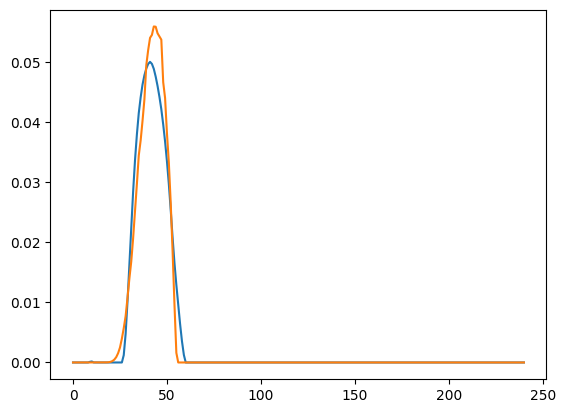

In [12]:
NUM=30000
plt.plot(dose.specs[:,NUM].cpu().detach())
plt.plot(specs[NUM,:])

In [13]:
#np.save('roughrestoredspecs2.npy',dose.specs.data.cpu().detach().numpy())

In [15]:
specsrestored=np.load('roughrestoredspecs2.npy')

In [16]:
set([col.split(',')[1][2:-1] for col in Alldata.columns[:-1]])

{'Ag', 'Cu', 'Mo', 'Pd', 'Rh', 'W'}

In [17]:
class ElementClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=torch.nn.Conv1d(1,32,3,padding=1)
        self.bn1=torch.nn.BatchNorm1d(32)
        self.conv2=torch.nn.Conv1d(32,1,3,padding=1)
        self.bn2=torch.nn.BatchNorm1d(1)
        self.classifier=torch.nn.Linear(1000,7)
        self.linear=torch.nn.Linear(1000,1000)
        self.activation=torch.nn.functional.elu
    def forward(self,x):
        b,c,l=x.shape
        y=self.bn1(self.activation(self.conv1(x)))
        y=self.bn2(self.activation(self.conv2(y)))
        y=self.activation(self.linear(y.reshape(b,-1)))
        y=self.classifier(y)
        return y.softmax(1)

In [18]:
def trainstepClass(model,inps,targets, optimizer,lossfn=torch.nn.CrossEntropyLoss()):
    optimizer.zero_grad()
    out=model(inps)
    loss=lossfn(out, targets)
    loss.backward()
    optimizer.step()
    onehot=torch.nn.functional.one_hot(out.argmax(-1),num_classes=7)
    #print(onehot.shape, targets.shape)
    #print((out).mean(0),targets.mean(0))
    acc=(onehot*targets).sum(0).sum(0)/targets.shape[0]
    #mean=one
    return loss,acc#,mean

In [21]:
classifier=torch.load('classifier.pt').cuda()

In [29]:
#torch.save(classifier,'classifier.pt')

In [27]:
classifier=ElementClassifier().to(float).cuda()
optimizer=torch.optim.Adam(classifier.parameters(),lr=0.0001)
lossfn=torch.nn.CrossEntropyLoss()
#inps=specsrestored
inps=distributions.T
inps=torch.tensor(inps.T).unsqueeze(1).to(float).cuda()#[:10000]
targlist=[(col.split(',')[0][2:-1],col.split(',')[1][2:-1]) for col in Alldata.columns[:-1]]#[:10000]
encoder={}
decoder={}
losses=[]
accs=[]
vallosses=[]
valaccs=[]
for i,k in enumerate(set(targlist)):
    encoder[k]=i
    decoder[i]=k
targs=torch.nn.functional.one_hot(torch.tensor([encoder[targ] for targ in targlist])).to(float).cuda()
dataset = torch.utils.data.TensorDataset(inps, targs)
train,test=torch.utils.data.random_split(dataset,[51561-2048,2048])
loader=torch.utils.data.DataLoader(train, batch_size=8192*2//8, shuffle=True)
for epoch in range(1000):
    for i,batch in enumerate(loader):
        inp,targ=batch
        #A=i%25
        #A=0
        #inp,targ=inps[A*2000:A*2000+2000],targs[A*2000:A*2000+2000]
        loss,acc=trainstepClass(classifier,inp*100,targ,optimizer)
    print(loss,acc.cpu().numpy(),epoch,i)
        #if i%100==0:
    losses.append(loss.detach().cpu().numpy())
    accs.append(acc.detach().cpu().numpy())
    with torch.no_grad():
        Ans=classifier(test[:][0]*100)
        acc=(Ans.argmax(1)==test[:][1].argmax(1)).sum()/len(test)
        valloss=torch.nn.CrossEntropyLoss()(Ans, test[:][1])
        valaccs.append(acc.detach().cpu().numpy())
        vallosses.append(valloss.detach().cpu().numpy())
        print('val_acc' ,acc.cpu().numpy(),epoch)

tensor(1.3603, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8033240997229917 0 24
val_acc 0.81396484 0
tensor(1.3265, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8365650969529086 1 24
val_acc 0.8144531 1
tensor(1.3319, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8310249307479224 2 24
val_acc 0.8129883 2
tensor(1.3376, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8282548476454293 3 24
val_acc 0.8144531 3
tensor(1.3669, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.7950138504155124 4 24
val_acc 0.8144531 4
tensor(1.3549, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8116343490304709 5 24
val_acc 0.81347656 5
tensor(1.3546, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8088642659279779 6 24
val_acc 0.81689453 6
tensor(1.3303, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8337950138504155 7 24
val_acc 0.8071289 7
tensor(1.3545, device='cuda:0

tensor(1.3175, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8448753462603878 67 24
val_acc 0.81347656 67
tensor(1.3436, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.817174515235457 68 24
val_acc 0.81933594 68
tensor(1.3664, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.7922437673130194 69 24
val_acc 0.81884766 69
tensor(1.3538, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8060941828254847 70 24
val_acc 0.81933594 70
tensor(1.3677, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.7922437673130194 71 24
val_acc 0.8198242 71
tensor(1.3512, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8088642659279779 72 24
val_acc 0.8198242 72
tensor(1.3668, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.7950138504155124 73 24
val_acc 0.81933594 73
tensor(1.3421, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8199445983379502 74 24
val_acc 0.81933594 74
tensor(1.32

tensor(1.3289, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8310249307479224 133 24
val_acc 0.8203125 133
tensor(1.3421, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8199445983379502 134 24
val_acc 0.8203125 134
tensor(1.3339, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8282548476454293 135 24
val_acc 0.8203125 135
tensor(1.3265, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8337950138504155 136 24
val_acc 0.8198242 136
tensor(1.3305, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8282548476454293 137 24
val_acc 0.8203125 137
tensor(1.3246, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8365650969529086 138 24
val_acc 0.8203125 138
tensor(1.3329, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8282548476454293 139 24
val_acc 0.8203125 139
tensor(1.3641, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.7950138504155124 140 24
val_acc 0.8203125 140


tensor(1.3325, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8282548476454293 199 24
val_acc 0.82177734 199
tensor(1.3130, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8476454293628809 200 24
val_acc 0.8208008 200
tensor(1.2966, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8642659279778393 201 24
val_acc 0.82177734 201
tensor(1.3336, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8254847645429363 202 24
val_acc 0.8208008 202
tensor(1.3184, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8421052631578947 203 24
val_acc 0.8203125 203
tensor(1.3189, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8421052631578947 204 24
val_acc 0.82177734 204
tensor(1.3259, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8337950138504155 205 24
val_acc 0.82177734 205
tensor(1.3378, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8227146814404432 206 24
val_acc 0.82128906

tensor(1.3106, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.850415512465374 265 24
val_acc 0.8330078 265
tensor(1.3458, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.814404432132964 266 24
val_acc 0.83154297 266
tensor(1.3161, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8448753462603878 267 24
val_acc 0.83203125 267
tensor(1.3181, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8421052631578947 268 24
val_acc 0.8330078 268
tensor(1.3250, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8365650969529086 269 24
val_acc 0.83251953 269
tensor(1.3375, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8199445983379502 270 24
val_acc 0.8339844 270
tensor(1.3467, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.814404432132964 271 24
val_acc 0.8334961 271
tensor(1.3154, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8448753462603878 272 24
val_acc 0.83447266 272

tensor(1.2274, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9501385041551247 331 24
val_acc 0.9140625 331
tensor(1.2387, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9279778393351801 332 24
val_acc 0.9160156 332
tensor(1.2564, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9168975069252078 333 24
val_acc 0.9067383 333
tensor(1.2392, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9335180055401662 334 24
val_acc 0.9165039 334
tensor(1.2335, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9335180055401662 335 24
val_acc 0.9189453 335
tensor(1.2589, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9168975069252078 336 24
val_acc 0.91308594 336
tensor(1.2251, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9473684210526315 337 24
val_acc 0.91552734 337
tensor(1.2492, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9196675900277008 338 24
val_acc 0.9213867 33

tensor(1.2212, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9445983379501385 397 24
val_acc 0.9506836 397
tensor(1.2279, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9390581717451524 398 24
val_acc 0.9501953 398
tensor(1.2179, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9473684210526315 399 24
val_acc 0.9482422 399
tensor(1.2189, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9473684210526315 400 24
val_acc 0.9506836 400
tensor(1.2168, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9501385041551247 401 24
val_acc 0.95166016 401
tensor(1.2139, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9529085872576177 402 24
val_acc 0.94873047 402
tensor(1.2365, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9279778393351801 403 24
val_acc 0.95166016 403
tensor(1.2172, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9473684210526315 404 24
val_acc 0.94970703 

tensor(1.2131, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9529085872576177 463 24
val_acc 0.953125 463
tensor(1.2170, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9473684210526315 464 24
val_acc 0.95214844 464
tensor(1.2195, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9445983379501385 465 24
val_acc 0.95214844 465
tensor(1.2100, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9529085872576177 466 24
val_acc 0.953125 466
tensor(1.2075, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9584487534626038 467 24
val_acc 0.95214844 467
tensor(1.2022, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.96398891966759 468 24
val_acc 0.953125 468
tensor(1.2094, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9556786703601108 469 24
val_acc 0.9526367 469
tensor(1.1977, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9667590027700831 470 24
val_acc 0.9536133 470
te

tensor(1.2070, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9584487534626038 529 24
val_acc 0.9550781 529
tensor(1.2042, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.961218836565097 530 24
val_acc 0.9550781 530
tensor(1.2109, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9556786703601108 531 24
val_acc 0.9555664 531
tensor(1.2230, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9418282548476454 532 24
val_acc 0.9560547 532
tensor(1.2262, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9390581717451524 533 24
val_acc 0.95654297 533
tensor(1.2010, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.96398891966759 534 24
val_acc 0.9560547 534
tensor(1.2079, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.961218836565097 535 24
val_acc 0.95458984 535
tensor(1.2145, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9501385041551247 536 24
val_acc 0.9555664 536
te

tensor(1.2006, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.96398891966759 595 24
val_acc 0.9633789 595
tensor(1.2010, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9667590027700831 596 24
val_acc 0.9633789 596
tensor(1.2037, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.961218836565097 597 24
val_acc 0.9633789 597
tensor(1.2039, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.961218836565097 598 24
val_acc 0.9633789 598
tensor(1.2001, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9667590027700831 599 24
val_acc 0.9638672 599
tensor(1.1879, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9778393351800554 600 24
val_acc 0.96435547 600
tensor(1.2005, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.96398891966759 601 24
val_acc 0.9628906 601
tensor(1.2010, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.96398891966759 602 24
val_acc 0.96240234 602
tensor

tensor(1.1910, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9750692520775623 661 24
val_acc 0.9633789 661
tensor(1.2066, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9556786703601108 662 24
val_acc 0.96484375 662
tensor(1.1907, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9750692520775623 663 24
val_acc 0.96435547 663
tensor(1.2126, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9529085872576177 664 24
val_acc 0.9628906 664
tensor(1.1878, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9778393351800554 665 24
val_acc 0.96484375 665
tensor(1.2033, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.961218836565097 666 24
val_acc 0.9658203 666
tensor(1.2150, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9501385041551247 667 24
val_acc 0.9633789 667
tensor(1.1878, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9778393351800554 668 24
val_acc 0.9614258 66

tensor(1.1801, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9861495844875346 727 24
val_acc 0.96728516 727
tensor(1.1962, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9695290858725761 728 24
val_acc 0.9682617 728
tensor(1.2067, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9584487534626038 729 24
val_acc 0.96972656 729
tensor(1.1830, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9833795013850416 730 24
val_acc 0.96875 730
tensor(1.1899, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9750692520775623 731 24
val_acc 0.96777344 731
tensor(1.1935, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9722991689750693 732 24
val_acc 0.9682617 732
tensor(1.1849, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9806094182825484 733 24
val_acc 0.9667969 733
tensor(1.1884, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9778393351800554 734 24
val_acc 0.97021484 73

tensor(1.1864, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9806094182825484 793 24
val_acc 0.98046875 793
tensor(1.1824, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9833795013850416 794 24
val_acc 0.9790039 794
tensor(1.1876, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9778393351800554 795 24
val_acc 0.97998047 795
tensor(1.1995, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9667590027700831 796 24
val_acc 0.9794922 796
tensor(1.2064, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9584487534626038 797 24
val_acc 0.98046875 797
tensor(1.1956, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9695290858725761 798 24
val_acc 0.9794922 798
tensor(1.1775, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9889196675900277 799 24
val_acc 0.97998047 799
tensor(1.1988, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9667590027700831 800 24
val_acc 0.98095703

tensor(1.1851, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9806094182825484 859 24
val_acc 0.97802734 859
tensor(1.1803, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9861495844875346 860 24
val_acc 0.9838867 860
tensor(1.1878, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9778393351800554 861 24
val_acc 0.9838867 861
tensor(1.1910, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9750692520775623 862 24
val_acc 0.98339844 862
tensor(1.2040, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.961218836565097 863 24
val_acc 0.9819336 863
tensor(1.1741, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9916897506925207 864 24
val_acc 0.98291016 864
tensor(1.1930, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9722991689750693 865 24
val_acc 0.9814453 865
tensor(1.1770, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9889196675900277 866 24
val_acc 0.9794922 86

tensor(1.1873, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9778393351800554 925 24
val_acc 0.98339844 925
tensor(1.1792, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9861495844875346 926 24
val_acc 0.9819336 926
tensor(1.1822, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9833795013850416 927 24
val_acc 0.98291016 927
tensor(1.1908, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9750692520775623 928 24
val_acc 0.9824219 928
tensor(1.2190, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9473684210526315 929 24
val_acc 0.96728516 929
tensor(1.1752, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9916897506925207 930 24
val_acc 0.9790039 930
tensor(1.1801, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9861495844875346 931 24
val_acc 0.9838867 931
tensor(1.1971, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9695290858725761 932 24
val_acc 0.984375 93

tensor(1.3312, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8365650969529086 991 24
val_acc 0.81640625 991
tensor(1.3105, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8559556786703602 992 24
val_acc 0.86035156 992
tensor(1.2693, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.8975069252077562 993 24
val_acc 0.9423828 993
tensor(1.2018, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9667590027700831 994 24
val_acc 0.9794922 994
tensor(1.1890, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9778393351800554 995 24
val_acc 0.9848633 995
tensor(1.1980, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9667590027700831 996 24
val_acc 0.9848633 996
tensor(1.1714, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9944598337950139 997 24
val_acc 0.9848633 997
tensor(1.1799, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward1>) 0.9861495844875346 998 24
val_acc 0.984375 998

In [30]:
y_pred=Ans.argmax(1).cpu() 
y_true=test[:][1].argmax(1).cpu()

In [31]:
np.save('losses.npy',np.array(losses))
np.save('accs.npy',np.array(accs))
np.save('vallosses.npy',np.array(vallosses))
np.save('valaccs.npy',np.array(valaccs))
np.save('pred.npy',np.array(y_pred))
np.save('true.npy',np.array(y_true))

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [33]:
cm=confusion_matrix(Ans.argmax(1).cpu(), test[:][1].argmax(1).cpu())

In [34]:
cm

array([[147,   0,   0,   0,   0,   0,   0],
       [  0, 283,   0,   1,   0,   0,   0],
       [  0,   0, 324,   0,   0,   0,   0],
       [  0,   2,   0, 333,   0,   0,   0],
       [  0,   9,   0,   0, 318,   0,   0],
       [  0,  18,   0,   0,   0, 295,   0],
       [  0,   2,   0,   0,   0,   0, 316]])

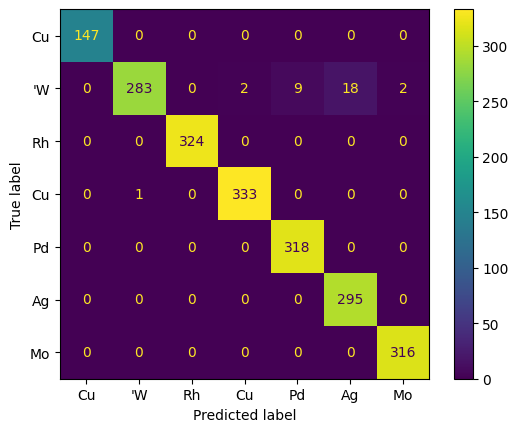

In [35]:
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_true, 
                                        display_labels=[str(decoder[i])[-4:-2] for i in range(7)])

In [40]:
predsall=[]
with torch.no_grad():
    for i in range(inps.shape[0]//2048+1):
        predsall=predsall+list(classifier(inps[2048*i:2048*i+2048]*100).argmax(-1).cpu().numpy())
    np.save('predsall.npy',np.array(predsall))

In [87]:
class NeuralFixer(torch.nn.Module):
    def __init__(self, in_channels=1):
        super(NeuralFixer, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels, 8, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv1d(8, 2, kernel_size=3, padding=1)
        # Layer 2
        self.conv3 = torch.nn.Conv1d(2, 241, kernel_size=241, padding=0,bias=True)
        self.relu =torch.nn.functional.relu
        self.tanh=torch.nn.functional.tanh
    def forward(self, z):
        B,C,W=z.shape
        #x = self.relu(self.adapt_nn(z)).cuda()
        #x = x.view(x.size(0), self.in_channels, self.length // 2 // 2 // 2)
        x = self.relu(self.conv1(z))
        x = self.relu(self.conv2(x))
        x = self.tanh(self.conv3(x))
        out =x.reshape(B,-1)
        return out
def trainstepfixer(model,inp,target, optimizer,lossfn=torch.nn.L1Loss()):
    optimizer.zero_grad()
    out=model(inp)
    loss=lossfn(out, target)*100
    loss.backward()
    optimizer.step()    
    return loss

array([1, 0, 3, ..., 5, 2, 4], dtype=int64)

In [76]:
Alldata=Alldata.fillna(0)
diff=torch.tensor(np.array(Alldata)[:,:-1]-specsrestored)

(51561, 241)

In [ ]:
predsall=np.load('predsall.npy')
alldata=np.array(Alldata)[:,:-1]
nfixers=[NeuralFixer().to(float) for i in range(7)]
for i in range(7):
    inpchunk=torch.tensor(specsrestored[:,predsall==i].T*10).unsqueeze(1).to(float)#.cuda()
    targchunk=torch.tensor(diff[:,predsall==i].T*10).to(float)#.cuda()
    optimizer=torch.optim.Adam(nfixers[i].parameters())
    for ctr in range(500):
        loss=trainstepfixer(nfixers[i],inpchunk,targchunk,optimizer)
        if ctr%10==0:
            print(loss)

In [ ]:
with torch.no_grad():
    corrected=specsrestored.T.copy()*10
    for i in range(7):
        chunk=torch.tensor(corrected[predsall==i,:]).unsqueeze(1)
        corrected[predsall==i,:]=corrected[predsall==i,:]+nfixers[i](chunk).numpy()

In [ ]:
for i, model in enumerate(nfixers):
    torch.save('correctormodel_{}.pt'.format(encoder[i]),model)

In [ ]:
np.abs((specsrestored-alldata)).mean()